In [ ]:
pip install sage-importance

In [ ]:
pip install shap

In [ ]:
!pip install lightgbm

In [1]:
### Import libraries
import pandas as pd

from sklearn.preprocessing import StandardScaler

from sklearn import model_selection
import xgboost as xgb

import joblib as jb

import shap

In [2]:
### Import data
feature_matrix = pd.read_pickle('D:\\jupyterDatasets\\20221112_table_feature_matrix.csv')
target = pd.read_pickle('D:\\jupyterDatasets\\20221119_table_target.csv')

print(feature_matrix.shape)
print(target.shape)

(836553, 70)
(836553,)


In [3]:
### Train/test split
X_train, X_test, y_train, y_test = model_selection.train_test_split(feature_matrix, target, test_size=0.2, random_state=1)

### Scaling for Lasso
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)
train_scaled_df = pd.DataFrame(train_scaled, columns = X_train.columns)
test_scaled_df = pd.DataFrame(test_scaled, columns = X_test.columns)

### XGBoost datasets
train = xgb.DMatrix(data=X_train, label=y_train)
test = xgb.DMatrix(data=X_test, label=y_test)

print('Prevalence y train:', round(sum(y_train) / len(y_train), 4))
print('Prevalence y test:', round(sum(y_test) / len(y_test), 4))

Prevalence y train: 0.4234
Prevalence y test: 0.423


In [4]:
# Import models
en_clf = jb.load('C:\\Users\\Megaport\\Desktop\\jupyterNotebook\\grid_search\\optimal_model_en.joblib')
xgb_clf = jb.load('C:\\Users\\Megaport\\Desktop\\jupyterNotebook\\grid_search\\optimal_xgb.joblib')
lgbm_clf = jb.load('C:\\Users\\Megaport\\Desktop\\jupyterNotebook\\grid_search\\LGBM.joblib')

In [5]:
# SHAP en
explainer_en = shap.LinearExplainer(en_clf, train_scaled, link=shap.links.logit)
%time shap_values_en = explainer_en.shap_values(test_scaled)

CPU times: total: 234 ms
Wall time: 78.8 ms


In [6]:
# SHAP xgb
explainer_xgb =  shap.TreeExplainer(xgb_clf)
%time shap_values_xgb = explainer_xgb.shap_values(test)

CPU times: total: 17min 54s
Wall time: 4min 48s


In [7]:
# SHAP lgbm
explainer_lgbm =  shap.TreeExplainer(lgbm_clf)
%time shap_values_lgbm = explainer_xgb.shap_values(test_scaled)

CPU times: total: 17min 37s
Wall time: 4min 34s


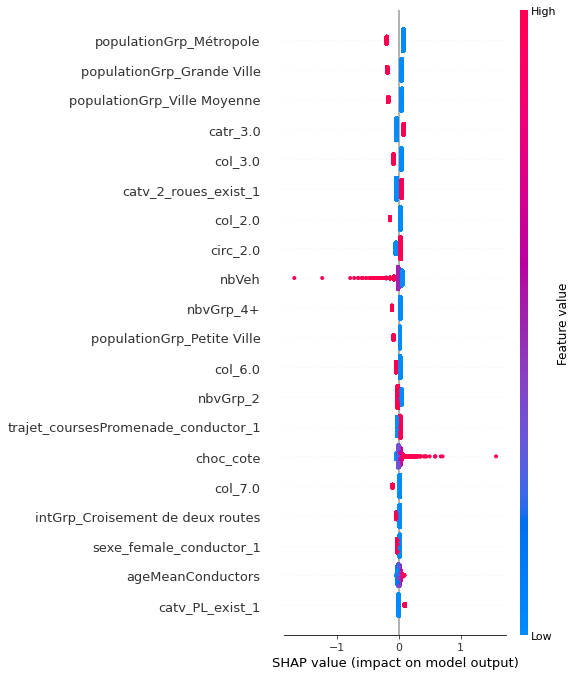

In [24]:
### SHAP plot en - Relation of variables
shap.summary_plot(shap_values_en, test_scaled_df, plot_type='dot')

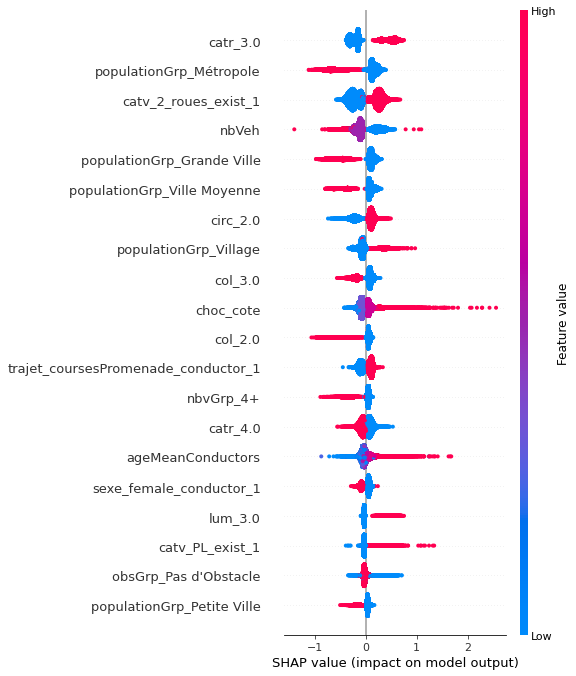

In [22]:
### SHAP plot xgb - Relation of variables
shap.summary_plot(shap_values_xgb, X_test, plot_type='dot')

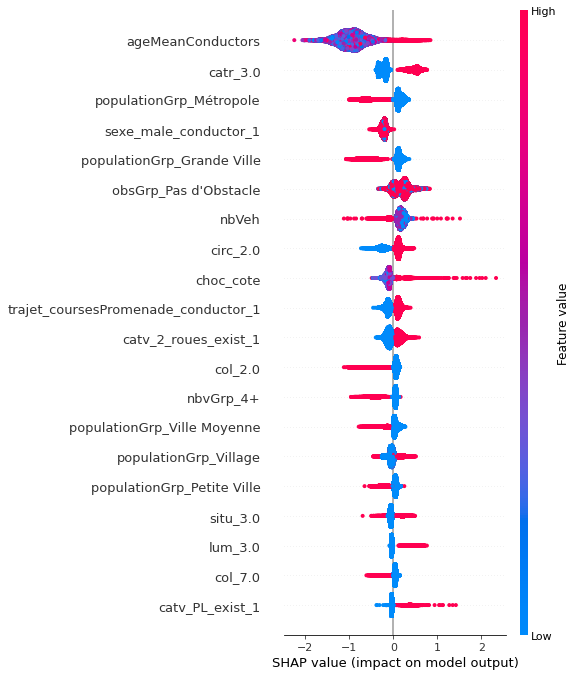

In [8]:
### SHAP plot lgbm - Relation of variables
shap.summary_plot(shap_values_lgbm, X_test, plot_type='dot')

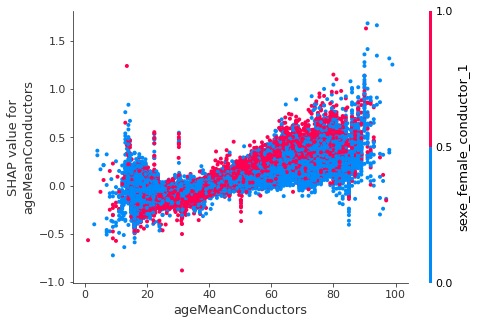

In [35]:
### SHAP plot xgb - Relation target with 2 variables
shap.dependence_plot("ageMeanConductors", shap_values_xgb, X_test, interaction_index= 'sexe_female_conductor_1')

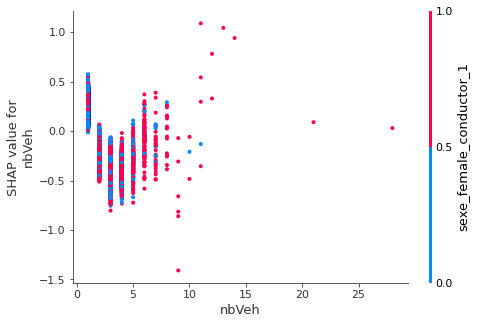

In [36]:
### SHAP plot xgb - Relation target with 2 variables
shap.dependence_plot("nbVeh", shap_values_xgb, X_test, interaction_index= 'sexe_female_conductor_1')

In [40]:
### SHAP plot - Sample order by similarity
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[:1000], X_test[:1000])

In [41]:
### SHAP plot - Impact of each modality for one person
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[0, :], X_test.iloc[0, :])

### Waterfall plots

In [ ]:
from shap import Explainer, Explanation

In [ ]:
explainer = Explainer(en_clf)
sv = explainer(train)

In [ ]:
sv.base_values

In [ ]:
### Waterfall plot for observation 1
explainer = Explainer(xgb_clf)
sv = explainer(X_train)

exp = Explanation(sv[:,:,6], sv.base_values[:,6], X_train, feature_names=None)
idx = 7 # datapoint to explain
waterfall_plot(exp[idx])

In [ ]:
### Waterfall plot for observation 1
explainer = Explainer(xgb_clf)
sv = explainer(X_train)

exp = Explanation(sv[:,6], sv.base_values, X_train, feature_names=None)
idx = 7 # datapoint to explain
waterfall(exp[idx])

In [ ]:
shap.plots.waterfall(exp[idx])

In [ ]:
### Waterfall plot for observation 1
shap.plots.waterfall(shap_values_xgb[0])

### Overall performances (by feature importance)

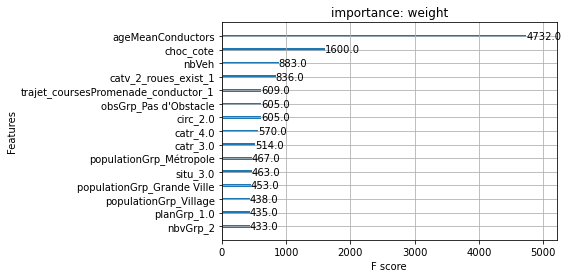

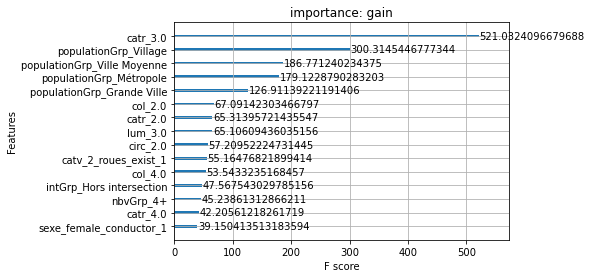

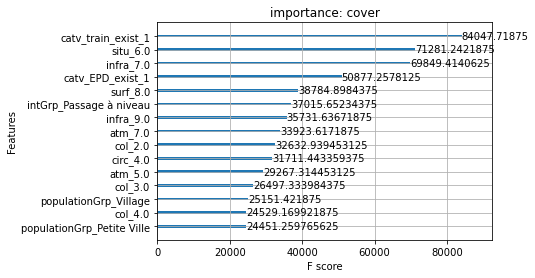

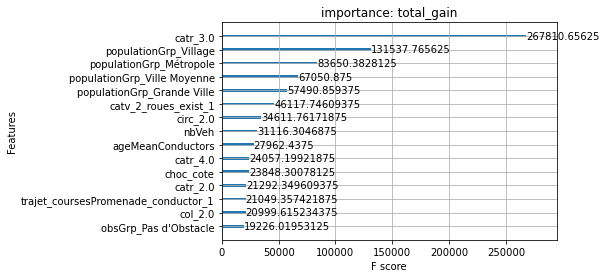

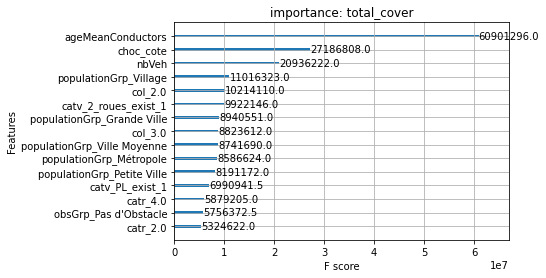

In [7]:
### Overall feature importance
types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

for f in types:
    xgb.plot_importance(xgb_clf, max_num_features=15, importance_type=f, title='importance: '+f);

### SAGE

In [ ]:
import sage

feature_names = X_test.columns

# Set up an imputer to handle missing features
imputer = sage.MarginalImputer(xgb_clf, X_test[:512])

# Set up an estimator
estimator = sage.PermutationEstimator(imputer, 'mse')

# Calculate SAGE values
sage_values = estimator(X_test, y_test)
sage_values.plot(feature_names)

### Predictions with XGBoost

In [5]:
### Import libraries
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

### Binarisation of predictions
# Train
xgb_preds_train = xgb_clf.predict(train)
# Test
xgb_preds_test = xgb_clf.predict(test)

# User case: comment calibrer notre modèle ?

##### Case-study: Discussion au gouvernement

*Le président vient d'entrer en fonction et il voudrait savoir combien d'argent il doit allouer au ministère des transports.*  

- <span style="background-color: #E8CCAB">*Le ministre des transports veut réduire au maximum le nombre d'accidents graves, quel que soit le prix.*</span>

- <span style="background-color: #ABE8CC">*Le ministre de l'économie veut optimiser les dépenses pour réduire le nombre d'accidents graves.*</span>

- <span style="background-color: #97BFF9">*L'expert analyste propose un entre-deux afin que les dépenses soient faites pour réduire un nombre important d'accidents graves, sans que cela concerne trop d'accidents bénins.*</span>

*D'un point de vue statistique, voici à quoi correspondrait chaque proposition.*

Ici, nous pouvons voir la distribution des probabilités pour chaque accident d'être grave ou non selon les prédictions du XGBoost.  

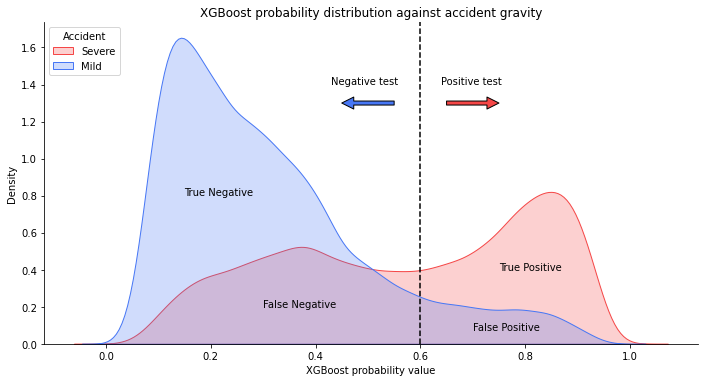

In [6]:
### Plot XGBoost probability values against accident observed values
# Import mudoles
import seaborn as sns

# Plot
density_plot_XGBoost = sns.displot(x=xgb_preds_test, hue=y_test, 
            kind='kde', fill=True, height=5, aspect=2, palette=['#4777F5', '#F54747'])
# Adding cosmetic options
density_plot_XGBoost._legend.remove()
plt.xlabel("XGBoost probability value")
plt.ylabel("Density")
plt.title("XGBoost probability distribution against accident gravity")
plt.legend(title='Accident', loc='upper left', labels=['Severe', 'Mild'])
plt.axvline(x=0.6, color='k', linestyle='--')
plt.annotate('', xy=(0.75, 1.3), xytext=(0.65, 1.3), arrowprops={'facecolor' : '#F54747'})
plt.annotate('', xy=(0.45, 1.3), xytext=(0.55, 1.3), arrowprops={'facecolor' : '#4777F5'})
plt.annotate("Positive test", (0.64, 1.4), fontsize=10)
plt.annotate("Negative test", (0.43, 1.4), fontsize=10)
plt.annotate("True Positive", (0.75, 0.4), fontsize=10)
plt.annotate("False Positive", (0.7, 0.075), fontsize=10)
plt.annotate("True Negative", (0.15, 0.8), fontsize=10)
plt.annotate("False Negative", (0.3, 0.2), fontsize=10);

A partir de ces distributions, nous pouvons choisir un seuil/cutoff et construire un tableau de contingence comme nous pouvons voir ci-dessous.  

|  | Negative Prediction | Positive Prediction |
| --- | --- | --- |
| **Mild accident** | True Negative | False Positive |
| **Severe accident** | False Negative | True Positive |

- <span style="background-color: #E8CCAB">*La proposition du ministre des transports requièrerait d'avoir un maximum de Vrai Positifs et donc d'utiliser un cutoff bas, qui permettrait de prédire plus de prédictions positives, i.e. plus d'accidents comme étant prédits graves. Cela augmenterait le nombre de Vrais Positifs mais également le nombre de Faux Positifs. L'impact serait d'augmenter le recall positif au prix d'une réduction de la précision positive.*  </span>

$$ PositiveRecall = {True Positive \over (True Positive + False Negative)} $$

- <span style="background-color: #ABE8CC">*La proposition du ministre de l'économie requièrerait d'avoir un maximum de Vrais Positifs parmi les accidents prédits positifs et donc d'utiliser un cutoff haut, qui permettrait d'augmenter la probabilité que les accidents prédits graves le soient vraiment. Cela baisserait le nombre de Faux Positifs mais également le nombre de Vrais Positifs. L'impact serait d'augmenter la précision positive, au coût d'une baisse du recall positif.*</span>

$$ PositivePrecision = {True Positive \over (True Positive + False Positive)} $$

- <span style="background-color: #97BFF9">*La proposition de l'expert analyste est un entre deux, pour lequel on essayerait d'avoir un nombre de Vrais Positifs et de Vrais Négatifs élevé, ce qui requièrerait d'utiliser le cutoff de Youden (cutoff maximisant la formule 'recall positif + recall négatif'). Il sera un bon compromis pour avoir un recall positif élevé tout en ayant un recall négatif élevé.*  </span>

$$ NegativeRecall = {True Negative \over (True Negative + False Positive)} $$

Le Youden Index est défini comme le cut off défini dans la formule suivante (cut off pour lequel on maximise la somme 'recall positif + recall négatif'):   

$max(PositiveRecall_{cutOff} + NegativeRecall_{cutOff})$ for $cutOff = 0,...,1$

2 questions à partir de cette problématique :  
- Quels cutoffs et quelles performances nous atteindrons pour chaque problématique ?  
- Quel modèle choisir pour optimiser les performances ?  

Une fois le cutoff choisi, l'objectif serait de déterminer les facteurs qui prédisent les accidents sévères afin de faire des optimisations sur les infrastructures (lumières supplémentaires, limitations de vitesse, sens de circulation, ...).  

##### Finding optimal cutoff for each model
##### 1- XGBoost

##### ROC curve

In [7]:
### AUC
fpr_xgb, tpr_xgb, seuils = roc_curve(y_test.astype('int'), xgb_preds_test, pos_label=1)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_auc_xgb

0.793617521470038

##### Youden index

In [8]:
### Function defining Youden index
def cutoff_youdens_j(fpr_xgb, tpr_xgb, seuils):
    j_scores = tpr_xgb - fpr_xgb
    j_ordered = sorted(zip(j_scores, seuils))
    return j_ordered[-1][1]

### Finding Youden cutoff
youden_cutoff_xgb = cutoff_youdens_j(fpr_xgb, tpr_xgb, seuils)

### Performance criteria at Youden cutoff
# print(classification_report(y_test.astype('int'), np.where(xgb_preds_test >= youden_cutoff_xgb, 1, 0)))
print('Youden index=', round(youden_cutoff_xgb, 2))

Youden index= 0.43


##### 80% recall and 80% precision cutoffs

In [9]:
### Performances at each cutoff
# Initiating DataFrame
df_cutoff_recall_precision_xgb = pd.DataFrame({'seuils':seuils, 'fpr_xgb':fpr_xgb, 'tpr_xgb':tpr_xgb})

# Filling DataFrame through loop
nb_neg_pred_neg = []
nb_pos_pred_neg = []
nb_neg_pred_pos = []
nb_pos_pred_pos = []
for i in df_cutoff_recall_precision_xgb['seuils']:
    nb_neg_pred_neg.append(np.logical_and(xgb_preds_test<i , y_test.astype('int')==0).sum())
    nb_pos_pred_neg.append(np.logical_and(xgb_preds_test<i , y_test.astype('int')==1).sum())
    nb_neg_pred_pos.append(np.logical_and(xgb_preds_test>=i , y_test.astype('int')==0).sum())
    nb_pos_pred_pos.append(np.logical_and(xgb_preds_test>=i , y_test.astype('int')==1).sum())

# Filling DataFrame with remaining estimands
df_cutoff_recall_precision_xgb['nb_neg_pred_neg'] = nb_neg_pred_neg
df_cutoff_recall_precision_xgb['nb_pos_pred_neg'] = nb_pos_pred_neg
df_cutoff_recall_precision_xgb['nb_neg_pred_pos'] = nb_neg_pred_pos
df_cutoff_recall_precision_xgb['nb_pos_pred_pos'] = nb_pos_pred_pos
df_cutoff_recall_precision_xgb['nb_neg'] = sum(y_test.astype('int')==0)
df_cutoff_recall_precision_xgb['nb_pos'] = sum(y_test.astype('int')==1)
df_cutoff_recall_precision_xgb['nb_pred_neg'] = df_cutoff_recall_precision_xgb['nb_neg_pred_neg'] + df_cutoff_recall_precision_xgb['nb_pos_pred_neg']
df_cutoff_recall_precision_xgb['nb_pred_pos'] = df_cutoff_recall_precision_xgb['nb_neg_pred_pos'] + df_cutoff_recall_precision_xgb['nb_pos_pred_pos']

# Computing performance criteria at each threshold
df_cutoff_recall_precision_xgb['precision_0'] = df_cutoff_recall_precision_xgb['nb_neg_pred_neg'] / df_cutoff_recall_precision_xgb['nb_pred_neg']
df_cutoff_recall_precision_xgb['precision_1'] = df_cutoff_recall_precision_xgb['nb_pos_pred_pos'] / df_cutoff_recall_precision_xgb['nb_pred_pos']
df_cutoff_recall_precision_xgb['recall_0'] = df_cutoff_recall_precision_xgb['nb_neg_pred_neg'] / df_cutoff_recall_precision_xgb['nb_neg']
df_cutoff_recall_precision_xgb['recall_1'] = df_cutoff_recall_precision_xgb['nb_pos_pred_pos'] / df_cutoff_recall_precision_xgb['nb_pos']

# f1 scores
df_cutoff_recall_precision_xgb['f1_0'] = 2 * (df_cutoff_recall_precision_xgb['precision_0'] * df_cutoff_recall_precision_xgb['recall_0']) / (df_cutoff_recall_precision_xgb['precision_0'] + df_cutoff_recall_precision_xgb['recall_0'])
df_cutoff_recall_precision_xgb['f1_1'] = 2 * (df_cutoff_recall_precision_xgb['precision_1'] * df_cutoff_recall_precision_xgb['recall_1']) / (df_cutoff_recall_precision_xgb['precision_1'] + df_cutoff_recall_precision_xgb['recall_1'])

In [10]:
df_cutoff_recall_precision_xgb

seuils   fpr_xgb   tpr_xgb  nb_neg_pred_neg  nb_pos_pred_neg  \
0      1.993183  0.000000  0.000000            96536            70775   
1      0.993183  0.000000  0.000014            96536            70774   
2      0.970981  0.000000  0.000410            96536            70746   
3      0.970972  0.000010  0.000410            96535            70746   
4      0.969202  0.000010  0.000509            96535            70739   
...         ...       ...       ...              ...              ...   
62067  0.025693  0.999565  0.999972               42                2   
62068  0.025673  0.999565  0.999986               42                1   
62069  0.018319  0.999917  0.999986                8                1   
62070  0.018140  0.999917  1.000000                8                0   
62071  0.012770  1.000000  1.000000                0                0   

       nb_neg_pred_pos  nb_pos_pred_pos  nb_neg  nb_pos  nb_pred_neg  \
0                    0                0   96536   70775       167311   
1                    0                1   96536   70775       167310   
2                    0               29   96536   70775       167282   
3                    1               29   96536   70775       167281   
4                    1               36   96536   70775       167274   
...                ...              ...     ...     ...          ...   
62067            96494            70773   96536   70775           44   
62068            96494            70774   96536   70775           43   
62069            96528            70774   96536   70775            9   
62070            96528            70775   96536   70775            8   
62071            96536            70775   96536   70775            0   

       nb_pred_pos  precision_0  precision_1  recall_0  recall_1      f1_0  \
0                0     0.576985          NaN  1.000000  0.000000  0.731757   
1                1     0.576989     1.000000  1.000000  0.000014  0.731760   
2               29     0.577085     1.000000  1.000000  0.000410  0.731838   
3               30     0.577083     0.966667  0.999990  0.000410  0.731833   
4               37     0.577107     0.972973  0.999990  0.000509  0.731852   
...            ...          ...          ...       ...       ...       ...   
62067       167267     0.954545     0.423114  0.000435  0.999972  0.000870   
62068       167268     0.976744     0.423117  0.000435  0.999986  0.000870   
62069       167302     0.888889     0.423031  0.000083  0.999986  0.000166   
62070       167303     1.000000     0.423035  0.000083  1.000000  0.000166   
62071       167311          NaN     0.423015  0.000000  1.000000       NaN   

           f1_1  
0           NaN  
1      0.000028  
2      0.000819  
3      0.000819  
4      0.001017  
...         ...  
62067  0.594626  
62068  0.594632  
62069  0.594547  
62070  0.594553  
62071  0.594533  

[62072 rows x 17 columns]

In [11]:
### Reducing number of columns
df_summary_xgb = round(df_cutoff_recall_precision_xgb[['seuils', 'precision_0', 'precision_1', 'recall_0', 'recall_1', 'f1_0', 'f1_1']], 2)

##### 2- Elastic Net

##### ROC curve

In [12]:
### Predictions
en_preds_test = en_clf.predict(test_scaled_df)

### AUC
fpr_en, tpr_en, seuils = roc_curve(y_test.astype('int'), en_preds_test, pos_label=1)
roc_auc_en = auc(fpr_en, tpr_en)
roc_auc_en

X has feature names, but ElasticNet was fitted without feature names


0.7694360477385229

##### Youden index

In [13]:
### Function defining Youden index
def cutoff_youdens_j(fpr_en, tpr_en, seuils):
    j_scores = tpr_en - fpr_en
    j_ordered = sorted(zip(j_scores, seuils))
    return j_ordered[-1][1]

### Finding Youden cutoff
youden_cutoff_en = cutoff_youdens_j(fpr_en, tpr_en, seuils)

### Performance criteria at Youden cutoff
# print(classification_report(y_test.astype('int'), np.where(en_preds_test >= youden_cutoff_en, 1, 0)))
print('Youden index=', round(youden_cutoff_en, 2))

Youden index= 0.46


##### 80% recall and 80% precision cutoffs

In [14]:
### Performances at each cutoff
# Initiating DataFrame
df_cutoff_recall_precision_en = pd.DataFrame({'seuils':seuils, 'fpr_en':fpr_en, 'tpr_en':tpr_en})

# Filling DataFrame through loop
nb_neg_pred_neg = []
nb_pos_pred_neg = []
nb_neg_pred_pos = []
nb_pos_pred_pos = []
for i in df_cutoff_recall_precision_en['seuils']:
    nb_neg_pred_neg.append(np.logical_and(en_preds_test<i , y_test.astype('int')==0).sum())
    nb_pos_pred_neg.append(np.logical_and(en_preds_test<i , y_test.astype('int')==1).sum())
    nb_neg_pred_pos.append(np.logical_and(en_preds_test>=i , y_test.astype('int')==0).sum())
    nb_pos_pred_pos.append(np.logical_and(en_preds_test>=i , y_test.astype('int')==1).sum())

# Filling DataFrame with remaining estimands
df_cutoff_recall_precision_en['nb_neg_pred_neg'] = nb_neg_pred_neg
df_cutoff_recall_precision_en['nb_pos_pred_neg'] = nb_pos_pred_neg
df_cutoff_recall_precision_en['nb_neg_pred_pos'] = nb_neg_pred_pos
df_cutoff_recall_precision_en['nb_pos_pred_pos'] = nb_pos_pred_pos
df_cutoff_recall_precision_en['nb_neg'] = sum(y_test.astype('int')==0)
df_cutoff_recall_precision_en['nb_pos'] = sum(y_test.astype('int')==1)
df_cutoff_recall_precision_en['nb_pred_neg'] = df_cutoff_recall_precision_en['nb_neg_pred_neg'] + df_cutoff_recall_precision_en['nb_pos_pred_neg']
df_cutoff_recall_precision_en['nb_pred_pos'] = df_cutoff_recall_precision_en['nb_neg_pred_pos'] + df_cutoff_recall_precision_en['nb_pos_pred_pos']

# Computing performance criteria at each threshold
df_cutoff_recall_precision_en['precision_0'] = df_cutoff_recall_precision_en['nb_neg_pred_neg'] / df_cutoff_recall_precision_en['nb_pred_neg']
df_cutoff_recall_precision_en['precision_1'] = df_cutoff_recall_precision_en['nb_pos_pred_pos'] / df_cutoff_recall_precision_en['nb_pred_pos']
df_cutoff_recall_precision_en['recall_0'] = df_cutoff_recall_precision_en['nb_neg_pred_neg'] / df_cutoff_recall_precision_en['nb_neg']
df_cutoff_recall_precision_en['recall_1'] = df_cutoff_recall_precision_en['nb_pos_pred_pos'] / df_cutoff_recall_precision_en['nb_pos']

# f1 scores
df_cutoff_recall_precision_en['f1_0'] = 2 * (df_cutoff_recall_precision_en['precision_0'] * df_cutoff_recall_precision_en['recall_0']) / (df_cutoff_recall_precision_en['precision_0'] + df_cutoff_recall_precision_en['recall_0'])
df_cutoff_recall_precision_en['f1_1'] = 2 * (df_cutoff_recall_precision_en['precision_1'] * df_cutoff_recall_precision_en['recall_1']) / (df_cutoff_recall_precision_en['precision_1'] + df_cutoff_recall_precision_en['recall_1'])

### Reducing number of columns
df_summary_en = round(df_cutoff_recall_precision_en[['seuils', 'precision_0', 'precision_1', 'recall_0', 'recall_1', 'f1_0', 'f1_1']], 2)

### Performance criteria against cutoff values

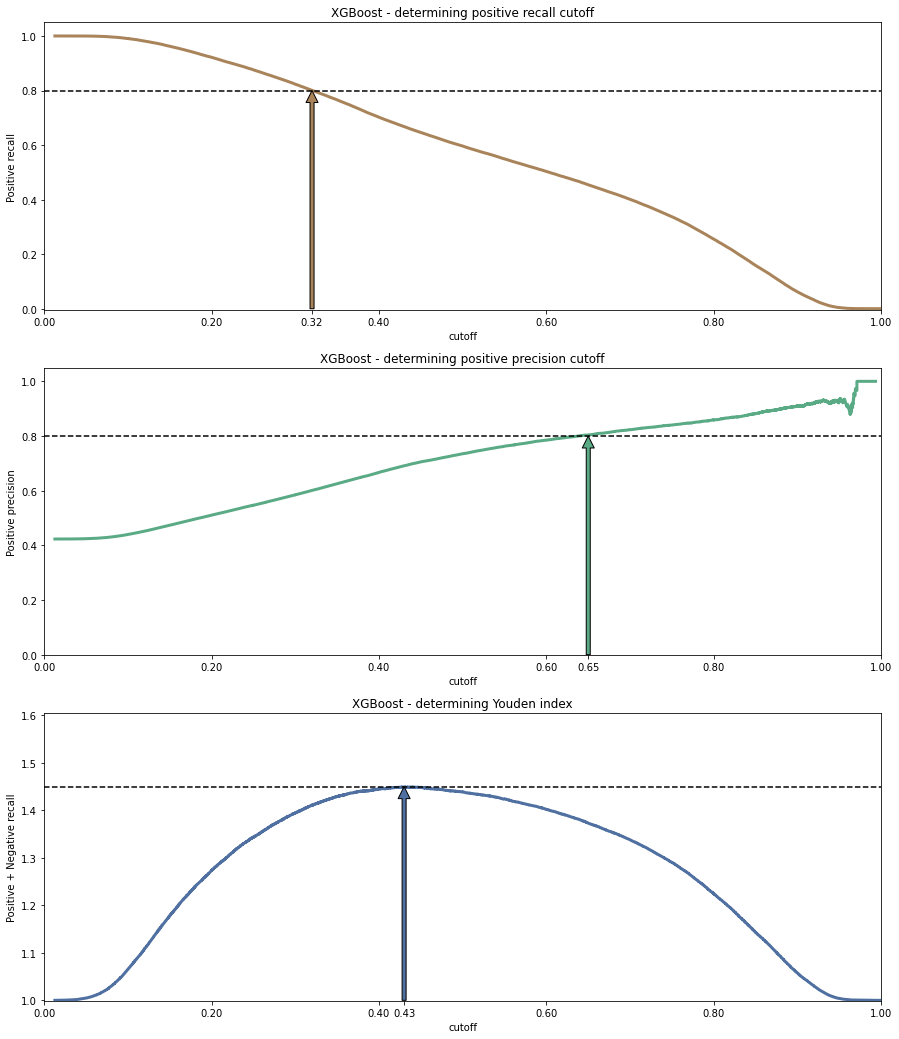

In [15]:
### Plots of XGBoost performance criteria against cutoff values
plt.figure(figsize=(15, 18))
# 80% positive recall
plt.subplot(3, 1, 1)
plt.plot(df_cutoff_recall_precision_xgb['seuils'], 
         df_cutoff_recall_precision_xgb['recall_1'], 
         color='#A9845A', linewidth=3)
plt.xlabel("cutoff")
plt.ylabel("Positive recall")
plt.xlim([0, 1])
plt.ylim([-0.005, 1.05])
plt.xticks([0, 0.2, 0.32, 0.4, 0.6, 0.8, 1])
plt.title("XGBoost - determining positive recall cutoff")
plt.axhline(y=0.8, color='k', linestyle='--')
plt.annotate('', xy=(0.32, 0.8), xytext=(0.32, 0), arrowprops={'facecolor' : '#A9845A'})
# 80% positive precision
plt.subplot(3, 1, 2)
plt.plot(df_cutoff_recall_precision_xgb['seuils'], 
         df_cutoff_recall_precision_xgb['precision_1'], 
         color='#5AAA85', linewidth=3)
plt.xlabel("cutoff")
plt.ylabel("Positive precision")
plt.xlim([0, 1])
plt.ylim([-0.003, 1.05])
plt.xticks([0, 0.2, 0.4, 0.6, 0.65, 0.8, 1])
plt.title("XGBoost - determining positive precision cutoff")
plt.axhline(y=0.8, color='k', linestyle='--')
plt.annotate('', xy=(0.65, 0.8), xytext=(0.65, 0), arrowprops={'facecolor' : '#5AAA85'})
# Youden index (maximizing positive and negative recall)
plt.subplot(3, 1, 3)
plt.plot(df_cutoff_recall_precision_xgb['seuils'], 
         df_cutoff_recall_precision_xgb['recall_1'] + df_cutoff_recall_precision_xgb['recall_0'], 
         color='#4F70A0', linewidth=3)
plt.xlabel("cutoff")
plt.ylabel("Positive + Negative recall")
plt.xlim([0, 1])
plt.ylim([0.999, 1.605])
plt.xticks([0, 0.2, 0.4, 0.43, 0.6, 0.8, 1])
plt.title("XGBoost - determining Youden index")
plt.axhline(y=0.78 + 0.67, color='k', linestyle='--')
plt.annotate('', xy=(0.43, 0.78 + 0.67), xytext=(0.43, 1), arrowprops={'facecolor' : '#4F70A0'});

##### Comparison of models

##### 1- XGBoost

In [16]:
##### XGBoost performances at cutoffs of interest
print(pd.concat([df_summary_xgb.loc[(round(df_cutoff_recall_precision_xgb.recall_1, 2)==0.8) | (round(df_cutoff_recall_precision_xgb.precision_1, 2)==0.8)].iloc[[0, -1]],
                 pd.DataFrame(df_summary_xgb.loc[(round(df_cutoff_recall_precision_xgb.seuils, 2)==round(youden_cutoff_xgb, 2))].iloc[-1]).transpose()]))

       seuils  precision_0  precision_1  recall_0  recall_1  f1_0  f1_1
12655    0.65         0.70         0.80      0.92      0.45  0.79  0.58
39408    0.32         0.81         0.60      0.60      0.80  0.69  0.69
27235    0.43         0.76         0.69      0.78      0.67  0.77  0.68


##### 2- Elastic Net

In [17]:
##### Elastic Net performances at cutoffs of interest
print(pd.concat([df_summary_xgb.loc[(round(df_cutoff_recall_precision_en.recall_1, 2)==0.8) | (round(df_cutoff_recall_precision_en.precision_1, 2)==0.8)].iloc[[0, -1]],
                 pd.DataFrame(df_summary_en.loc[(round(df_cutoff_recall_precision_en.seuils, 2)==round(youden_cutoff_en, 2))].iloc[-1]).transpose()]))

       seuils  precision_0  precision_1  recall_0  recall_1  f1_0  f1_1
11196    0.68         0.69         0.82      0.93      0.42  0.79  0.56
41752    0.30         0.82         0.58      0.56      0.83  0.67  0.68
25965    0.46         0.74         0.68      0.78      0.63  0.76  0.66


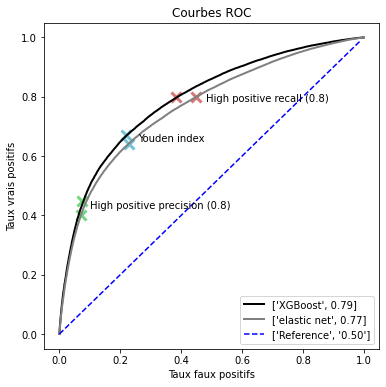

In [18]:
### ROC curves
plt.figure(figsize=(6, 6))
# High positive recall
plt.plot(1-0.617, 0.8, 'x', color='#D67676', markersize=10, mew=3)
plt.plot(1-0.55, 0.8, 'x', color='#D67676', markersize=10, mew=3)
# High positive precision
plt.plot(1-0.925, 0.45, 'x', color='#76D680', markersize=10, mew=3)
plt.plot(1-0.93, 0.4, 'x', color='#76D680', markersize=10, mew=3)
# Youden
plt.plot(1-0.78, 0.67, 'x', color='#76C3D6', markersize=10, mew=3)
plt.plot(1-0.77, 0.64, 'x', color='#76C3D6', markersize=10, mew=3)
# ROC
plt.plot(fpr_xgb, tpr_xgb, color='black', lw=2, label=['XGBoost', round(roc_auc_xgb, 2)])
plt.plot(fpr_en, tpr_en, color='grey', lw=2, label=['elastic net', round(roc_auc_en, 2)])
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), 'b--', label=['Reference', '0.50'])
plt.ylabel('Taux vrais positifs')
plt.xlabel('Taux faux positifs')
plt.title('Courbes ROC')
plt.legend(loc='lower right')
plt.annotate('High positive precision (0.8)', xy=(1-0.9, 0.425), xytext=(1-0.9, 0.425))
plt.annotate('High positive recall (0.8)', xy=(1-0.52, 0.785), xytext=(1-0.52, 0.785))
plt.annotate('Youden index', xy=(1-0.74, 0.65), xytext=(1-0.74, 0.65));

# Carefull, precision is not monotone

#### Training set

In [18]:
### Train contingency table at 0.5 cutoff
pd.crosstab(y_train, xgb_preds_train_bin05, colnames=['xgb_pred_train'], normalize=True)

xgb_pred_train         0         1
gravGrp_2_34                      
0               0.489945  0.086655
1               0.166279  0.257121

In [19]:
### Train contingency table at 0.3 cutoff
pd.crosstab(y_train, xgb_preds_train_bin03, colnames=['xgb_pred_train'], normalize=True)

xgb_pred_train         0         1
gravGrp_2_34                      
0               0.335252  0.241348
1               0.070015  0.353385

We can see above that more patients are predicted as positive.

In [20]:
### Performance criteria at 0.5 cutoff
print(classification_report(y_train.astype('int'), xgb_preds_train_bin05))

              precision    recall  f1-score   support

           0       0.75      0.85      0.79    385885
           1       0.75      0.61      0.67    283357

    accuracy                           0.75    669242
   macro avg       0.75      0.73      0.73    669242
weighted avg       0.75      0.75      0.74    669242



In [21]:
### Performance criteria at 0.3 cutoff
print(classification_report(y_train.astype('int'), xgb_preds_train_bin03))

              precision    recall  f1-score   support

           0       0.83      0.58      0.68    385885
           1       0.59      0.83      0.69    283357

    accuracy                           0.69    669242
   macro avg       0.71      0.71      0.69    669242
weighted avg       0.73      0.69      0.69    669242



As expected, we have increased positive recall while reducing negative precision.

#### Test set

In [22]:
### Test contingency table at 0.3 cutoff
pd.crosstab(y_test, xgb_preds_test_bin03, colnames=['xgb_pred_test'], normalize=True)

xgb_pred_test         0         1
gravGrp_2_34                     
0              0.329668  0.247318
1              0.074825  0.348190

In [23]:
### Performance criteria at 0.3 cutoff
print(classification_report(y_test.astype('int'), xgb_preds_test_bin03))

              precision    recall  f1-score   support

           0       0.82      0.57      0.67     96536
           1       0.58      0.82      0.68     70775

    accuracy                           0.68    167311
   macro avg       0.70      0.70      0.68    167311
weighted avg       0.72      0.68      0.68    167311



In [40]:
### Performance criteria at 0.5 cutoff
print(classification_report(y_test.astype('int'), xgb_preds_test_bin05))

              precision    recall  f1-score   support

           0       0.74      0.84      0.79     96536
           1       0.74      0.60      0.66     70775

    accuracy                           0.74    167311
   macro avg       0.74      0.72      0.72    167311
weighted avg       0.74      0.74      0.73    167311



In [24]:
### Performance criteria at 0.7 cutoff
print(classification_report(y_test.astype('int'), xgb_preds_test_bin07))

              precision    recall  f1-score   support

           0       0.68      0.94      0.79     96536
           1       0.82      0.40      0.54     70775

    accuracy                           0.71    167311
   macro avg       0.75      0.67      0.66    167311
weighted avg       0.74      0.71      0.68    167311



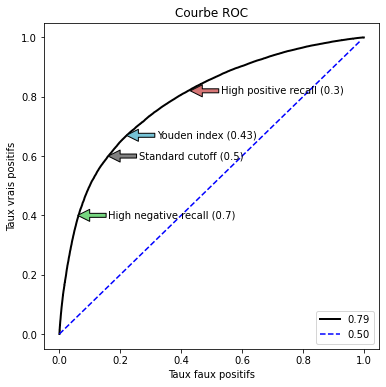

In [154]:
### ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr_xgb, tpr_xgb, color='black', lw=2, label=round(roc_auc_xgb, 2))
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), 'b--', label='0.50')
plt.ylabel('Taux vrais positifs')
plt.xlabel('Taux faux positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.annotate('High positive recall (0.3)', xy=(1-0.57, 0.82), xytext=(1-0.47, 0.81), arrowprops={'facecolor' : '#D67676'})
plt.annotate('Standard cutoff (0.5)', xy=(1-0.84, 0.60), xytext=(1-0.74, 0.59), arrowprops={'facecolor' : 'grey'})
plt.annotate('High negative recall (0.7)', xy=(1-0.94, 0.40), xytext=(1-0.84, 0.39), arrowprops={'facecolor' : '#76D680'})
plt.annotate('Youden index (0.43)', xy=(1-0.78, 0.67), xytext=(1-0.68, 0.66), arrowprops={'facecolor' : '#76C3D6'});

##### 3- LGBM

In [175]:
### Predictions
lgbm_preds_test = lgbm_clf.predict(test_scaled_df)

### AUC
fpr_lgbm, tpr_lgbm, seuils = roc_curve(y_test.astype('int'), lgbm_preds_test, pos_label=1)
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)
roc_auc_lgbm

### Performances at each cutoff
# Initiating DataFrame
df_cutoff_recall_precision_lgbm = pd.DataFrame({'seuils':seuils, 'fpr_lgbm':fpr_lgbm, 'tpr_lgbm':tpr_lgbm})

# Filling DataFrame through loop
nb_neg_pred_neg = []
nb_pos_pred_neg = []
nb_neg_pred_pos = []
nb_pos_pred_pos = []
for i in df_cutoff_recall_precision_lgbm['seuils']:
    nb_neg_pred_neg.append(np.logical_and(lgbm_preds_test<i , y_test.astype('int')==0).sum())
    nb_pos_pred_neg.append(np.logical_and(lgbm_preds_test<i , y_test.astype('int')==1).sum())
    nb_neg_pred_pos.append(np.logical_and(lgbm_preds_test>=i , y_test.astype('int')==0).sum())
    nb_pos_pred_pos.append(np.logical_and(lgbm_preds_test>=i , y_test.astype('int')==1).sum())

# Filling DataFrame with remaining estimands
df_cutoff_recall_precision_lgbm['nb_neg_pred_neg'] = nb_neg_pred_neg
df_cutoff_recall_precision_lgbm['nb_pos_pred_neg'] = nb_pos_pred_neg
df_cutoff_recall_precision_lgbm['nb_neg_pred_pos'] = nb_neg_pred_pos
df_cutoff_recall_precision_lgbm['nb_pos_pred_pos'] = nb_pos_pred_pos
df_cutoff_recall_precision_lgbm['nb_neg'] = sum(y_test.astype('int')==0)
df_cutoff_recall_precision_lgbm['nb_pos'] = sum(y_test.astype('int')==1)
df_cutoff_recall_precision_lgbm['nb_pred_neg'] = df_cutoff_recall_precision_lgbm['nb_neg_pred_neg'] + df_cutoff_recall_precision_lgbm['nb_pos_pred_neg']
df_cutoff_recall_precision_lgbm['nb_pred_pos'] = df_cutoff_recall_precision_lgbm['nb_neg_pred_pos'] + df_cutoff_recall_precision_lgbm['nb_pos_pred_pos']

# Computing performance criteria at each threshold
df_cutoff_recall_precision_lgbm['precision_0'] = df_cutoff_recall_precision_lgbm['nb_neg_pred_neg'] / df_cutoff_recall_precision_lgbm['nb_pred_neg']
df_cutoff_recall_precision_lgbm['precision_1'] = df_cutoff_recall_precision_lgbm['nb_pos_pred_pos'] / df_cutoff_recall_precision_lgbm['nb_pred_pos']
df_cutoff_recall_precision_lgbm['recall_0'] = df_cutoff_recall_precision_lgbm['nb_neg_pred_neg'] / df_cutoff_recall_precision_lgbm['nb_neg']
df_cutoff_recall_precision_lgbm['recall_1'] = df_cutoff_recall_precision_lgbm['nb_pos_pred_pos'] / df_cutoff_recall_precision_lgbm['nb_pos']

# f1 scores
df_cutoff_recall_precision_lgbm['f1_0'] = 2 * (df_cutoff_recall_precision_lgbm['precision_0'] * df_cutoff_recall_precision_lgbm['recall_0']) / (df_cutoff_recall_precision_lgbm['precision_0'] + df_cutoff_recall_precision_lgbm['recall_0'])
df_cutoff_recall_precision_lgbm['f1_1'] = 2 * (df_cutoff_recall_precision_lgbm['precision_1'] * df_cutoff_recall_precision_lgbm['recall_1']) / (df_cutoff_recall_precision_lgbm['precision_1'] + df_cutoff_recall_precision_lgbm['recall_1'])

### Reducing number of columns
df_summary_lgbm = round(df_cutoff_recall_precision_lgbm[['seuils', 'precision_0', 'precision_1', 'recall_0', 'recall_1', 'f1_0', 'f1_1']], 2)

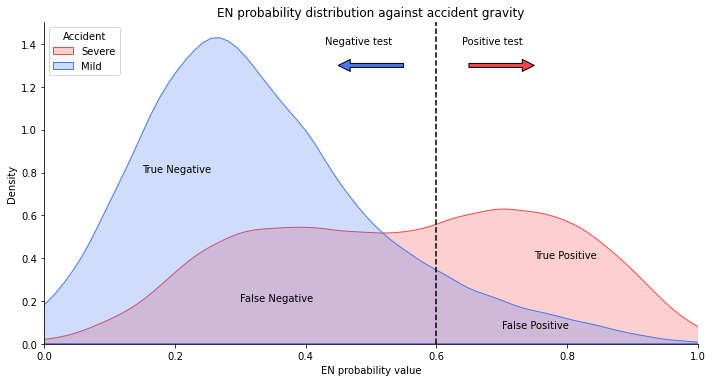

In [47]:
### Plot en probability values against accident observed values
# Import mudoles
import seaborn as sns

# Plot
density_plot_EN = sns.displot(x=en_preds_test, hue=y_test, 
            kind='kde', fill=True, height=5, aspect=2, palette=['#4777F5', '#F54747'])
# Adding cosmetic options
density_plot_EN._legend.remove()
plt.xlabel("EN probability value")
plt.ylabel("Density")
plt.xlim([0, 1])
plt.title("EN probability distribution against accident gravity")
plt.legend(title='Accident', loc='upper left', labels=['Severe', 'Mild'])
plt.axvline(x=0.6, color='k', linestyle='--')
plt.annotate('', xy=(0.75, 1.3), xytext=(0.65, 1.3), arrowprops={'facecolor' : '#F54747'})
plt.annotate('', xy=(0.45, 1.3), xytext=(0.55, 1.3), arrowprops={'facecolor' : '#4777F5'})
plt.annotate("Positive test", (0.64, 1.4), fontsize=10)
plt.annotate("Negative test", (0.43, 1.4), fontsize=10)
plt.annotate("True Positive", (0.75, 0.4), fontsize=10)
plt.annotate("False Positive", (0.7, 0.075), fontsize=10)
plt.annotate("True Negative", (0.15, 0.8), fontsize=10)
plt.annotate("False Negative", (0.3, 0.2), fontsize=10);